In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from typing import TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()

In [2]:
# 1. Define State
class PostState(TypedDict):
    messages: list
    summary: str
    post: str
    verify_result: Literal["pass", "revise"]
    revision_count: int
    tech_check: str
    style_check: str

In [3]:
# 2. Define Tools
@tool
def mock_paper_lookup(title: str) -> str:
    """Simulate paper retrieval and return a short abstract."""
    return (
        "LoRA is a low-rank adaptation technique for fine-tuning large language models. "
        "It enables efficient training by injecting low-rank matrices into transformer weights."
    )

@tool
def verify_technical_correctness(summary: str) -> str:
    """Returns 'pass' or 'revise' for technical accuracy (simulated)."""
    return "pass" if "LoRA" in summary else "revise"

@tool
def check_social_post_style(post: str) -> str:
    """Check post for platform-appropriate style. Simulated."""
    if len(post) > 300 or "@AIMakerspace" not in post:
        return "revise"
    return "pass"

In [4]:
# 3. Define Agent Executors
llm = ChatOpenAI(model="gpt-4o")

def create_tool_agent(system_prompt: str, tools: list):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder("messages"),
        MessagesPlaceholder("agent_scratchpad"),
    ])
    agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=prompt)
    return AgentExecutor(agent=agent, tools=tools)

def create_prompt_only_agent(system_prompt: str, output_key: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    chain = prompt | llm

    def run(state: dict):
        # Ensure messages is a proper list of LangChain message objects
        messages = state.get("messages", [])
        if not isinstance(messages, list):
            raise ValueError("Expected 'messages' to be a list")
        response = chain.invoke({"messages": messages})
        return {
            **state,
            output_key: response.content
        }

    return RunnableLambda(run)


In [5]:
# 4. Agents
research_agent = create_tool_agent(
    "You are a researcher. Use available tools to find ML paper content.", [mock_paper_lookup]
)

summarize_agent = create_prompt_only_agent(
    "You are a scientific summarizer. Generate a short, accurate summary.", "summary"
)

post_agent = create_prompt_only_agent(
    "You are a social media strategist. Write a LinkedIn post using the summary. The post MUST mention @AIMakerspace and MUST be under 300 characters. If you are revising, make sure to fix any issues with these requirements.",
    "post"
)

verify_agent = create_tool_agent(
    "You are a verification team. Check both accuracy and platform style.", 
    [verify_technical_correctness, check_social_post_style]
)

def verify_wrapper(state):
    summary = state.get("summary", "")
    post = state.get("post", "")
    tech_result = verify_technical_correctness(summary)
    style_result = check_social_post_style(post)
    revision_count = state.get("revision_count", 0)
    if tech_result == "pass" and style_result == "pass":
        verify_result = "pass"
    elif revision_count >= 3:
        verify_result = "pass"
    else:
        verify_result = "revise"
    return {
        **state,
        "verify_result": verify_result,
        "revision_count": revision_count + 1,
        "tech_check": tech_result,
        "style_check": style_result
    }

verify_node = RunnableLambda(verify_wrapper)

In [6]:
# 5. Router
def verify_output_router(state: PostState) -> Literal["pass", "revise"]:
    return state["verify_result"]

In [7]:
# 6. Define Graph
graph = StateGraph(PostState)

graph.add_node("research", research_agent)
graph.add_node("summarize", summarize_agent)
graph.add_node("draft_post", post_agent)
graph.add_node("verify", verify_node)

graph.set_entry_point("research")
graph.add_edge("research", "summarize")
graph.add_edge("summarize", "draft_post")
graph.add_edge("draft_post", "verify")

graph.add_conditional_edges("verify", verify_output_router, {
    "pass": END,
    "revise": "draft_post"
})

advanced_graph = graph.compile()

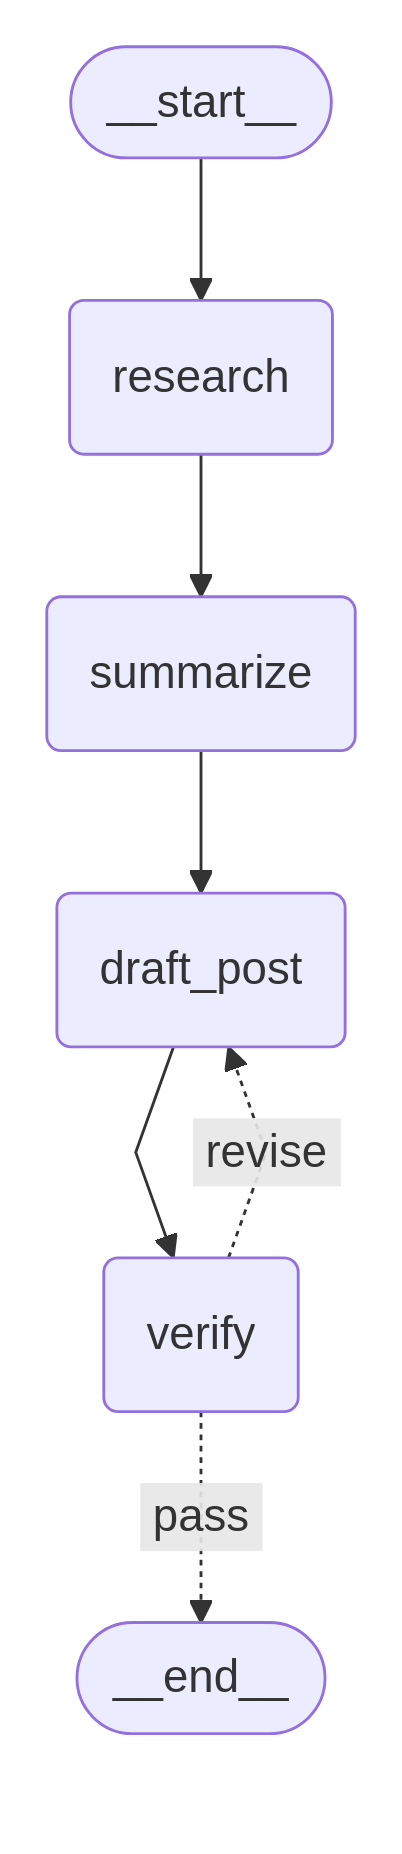

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        advanced_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)


In [9]:
# 7. Run Graph
paper_title = "LoRA: Low-Rank Adaptation of LLMs"
input_messages = [
    HumanMessage(content=f"Please write a LinkedIn post about the paper '{paper_title}'")
]

result = advanced_graph.invoke({"messages": input_messages, "revision_count": 0})

print("✅ Final Output:")
for m in result["messages"]:
    print(m.content)

print("\n📄 Summary:\n", result["summary"])
print("\n📝 Post:\n", result["post"])
print("\n🔍 Verify Result:", result["verify_result"])
print("\n🔁 Number of Revisions:", result["revision_count"])
print("\n🔬 Technical Check:", result["tech_check"])
print("🎨 Style Check:", result["style_check"])

✅ Final Output:
Please write a LinkedIn post about the paper 'LoRA: Low-Rank Adaptation of LLMs'

📄 Summary:
 🚀 Exciting advancements in AI! Just read the paper "LoRA: Low-Rank Adaptation of LLMs" and I am thrilled by its potential. LoRA introduces a method to efficiently adapt large language models (LLMs) by utilizing low-rank adaptation—significantly reducing the number of trainable parameters required, while maintaining high performance. This approach could revolutionize the way we fine-tune massive models, making them more accessible and adaptable for specific tasks without needing extensive computational resources. A must-read for anyone involved in AI and machine learning! #AI #MachineLearning #LoRA #Innovation

📝 Post:
 🔍 Exciting advancements in AI! Discover how 'LoRA: Low-Rank Adaptation of LLMs' is innovatively enhancing model efficiency without sacrificing performance. A must-read for AI enthusiasts! 

Thanks to @AIMakerspace for spotlighting transformative research. 📚 #AI #

/tmp/ipykernel_29081/2828212042.py:23: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  tech_result = verify_technical_correctness(summary)
